# 데이터 소개

활용 데이터셋

****Analytics: Job Change of Data Scientists****

빅 데이터 및 데이터 과학 분야에서 활발히 활동하고 있는 한 회사에서 제공하는 교육과정을 받은 후보자들의 정보

- enrollee_id : 후보자의 고유 ID
- city: 도시 코드
- city_ development _index : 도시의 개발 지수(축적)
- gender : 후보자의 성별
- relevent_experience : 후보자의 데이터 관련 직무 경험
- enrolled_university : 등록된 대학원, 대학 과정의 유형(있는 경우)
- education_level : 후보자의 학력
- major_discipline : 후보자의 교육 전공
- experience : 후보자 총 경력(년)
- company_size : 후보자가 현재 고용 되어 있는 회사의 직원 수
- company_type : 후보자가 현재 고용 되어 있는 회사의 유형
- last_new_job : 이전 직업과 현재 직업 간의 연수 차이
- training_hours : 교육 완료까지 걸린 시간
- target : 0 – 이직을 구하지 않음, 1 – 이직을 찾고 있음

## 문제 정의

회사에서 교육을 제공하는 목적은 교육 과정을 성공적으로 통과한 사람을 채용하고 싶기 때문이다.

하지만, 후보자들이 이직을 원하는 경우는 전체 중 약 25%로 회사에 고용 할 가능성이 있는 후보자 수가 적다.

때문에 회사는 교육과정을 성공적으로 통과 하고, 고용 될 가능성이 높은 지원자를 미리 예측 분류하여 교육과정에 소모되는 자원을 줄이고 교육의 질이나 계획을 수정하자고 한다.

지원자의 잠재력을 예측하고, 회사에 고용 될 가능성이 높은 지원자의 특성을 파악한다.

이 때 이직의사가 있는 후보자를 잠재적으로 고용 가능성이 높다고 판단 한다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 70% !important; }</style>"))

%config InlineBackend.figure_format='retina'

In [2]:
# 라이브러리

# EDA 및 시각화
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 제작
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from category_encoders.binary import BinaryEncoder
from xgboost import XGBClassifier
from sklearn.utils import class_weight
from sklearn.model_selection import RandomizedSearchCV


# 모델 평가
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import plot_confusion_matrix

In [3]:
# 데이터셋 불러오기

df = pd.read_csv('/Users/simcheol-u/Desktop/archive/aug_train.csv')

df.shape

(19158, 14)

In [4]:
# 데이터 셋이 충분히 크다고 판단 되기 때문에 Hold-out 교차검증
# train, val, test 데이터 분리

train, test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=True, random_state=42)
train, val = train_test_split(train, train_size=0.7, test_size=0.3, shuffle=True, random_state=42)

train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

train.shape, val.shape, test.shape

((10728, 14), (4598, 14), (3832, 14))

In [5]:
train.head()

enrollee_id      city  city_development_index gender  \
0         3166  city_100                   0.887   Male   
1        27566  city_103                   0.920   Male   
2        20587   city_91                   0.691    NaN   
3         7500   city_45                   0.890    NaN   
4        27149   city_71                   0.884   Male   

       relevent_experience enrolled_university education_level  \
0  Has relevent experience       no_enrollment        Graduate   
1  Has relevent experience       no_enrollment         Masters   
2  Has relevent experience       no_enrollment        Graduate   
3   No relevent experience       no_enrollment        Graduate   
4  Has relevent experience       no_enrollment         Masters   

  major_discipline experience company_size    company_type last_new_job  \
0             STEM         11          NaN             NaN            1   
1             STEM         13       10000+         Pvt Ltd            1   
2             STEM        NaN      100-500         Pvt Ltd            1   
3         No Major         11          NaN             NaN            2   
4             STEM         17        50-99  Funded Startup            1   

   training_hours  target  
0              36     0.0  
1              14     0.0  
2              56     0.0  
3              37     1.0  
4               6     0.0

# EDA & Pre-processing

In [6]:
# duplicated, null, unique, dtype 확인

def analysis_on_features(df):
    eda_results = pd.DataFrame()
    eda_results["null_count"] = df.isnull().sum()
    eda_results["num_unique_values"] = df.nunique()
    duplicated_rows = df.duplicated().sum()
    for col in df.columns:
        eda_results.loc[col, 'dtype'] = df[col].dtype

    return eda_results, duplicated_rows

In [7]:
train_results, train_duplicated_rows = analysis_on_features(train)
print(f"duplicated = {train_duplicated_rows}\n", train_results)

duplicated = 0
                         null_count  num_unique_values    dtype
enrollee_id                      0              10728    int64
city                             0                120   object
city_development_index           0                 91  float64
gender                        2581                  3   object
relevent_experience              0                  2   object
enrolled_university            228                  3   object
education_level                261                  5   object
major_discipline              1593                  6   object
experience                      27                 22   object
company_size                  3405                  8   object
company_type                  3528                  6   object
last_new_job                   226                  6   object
training_hours                   0                241    int64
target                           0                  2  float64


In [8]:
# index와 상응 하는 feature 제거

train.drop(columns='enrollee_id', inplace=True)

In [9]:
# 'city'와 'city_development_index'의 연관성 검증

unique_count = []

for x in train['city'].unique():
    if len(train.query(f"city == '{x}'")['city_development_index'].unique()) != 1:
        unique_count += x

unique_count

[]

In [10]:
# 'city'와 'city_development_index'는 1대 1 상응 하며, 중복되는 'city_development_index'값이 있어 unique의 차이를 보인다.

train.drop(columns='city', inplace=True)

In [11]:
# 'gender' nan값 'Other'로 보간 ('Other'은 모든 성별을 내포 하고있다.)
# !윤리적 문제 고민! < 내가 고려 해야 할 작업인가?

print(train['gender'].value_counts(normalize=True))
train['gender'].fillna('Other', inplace=True)

Male      0.904136
Female    0.082975
Other     0.012888
Name: gender, dtype: float64


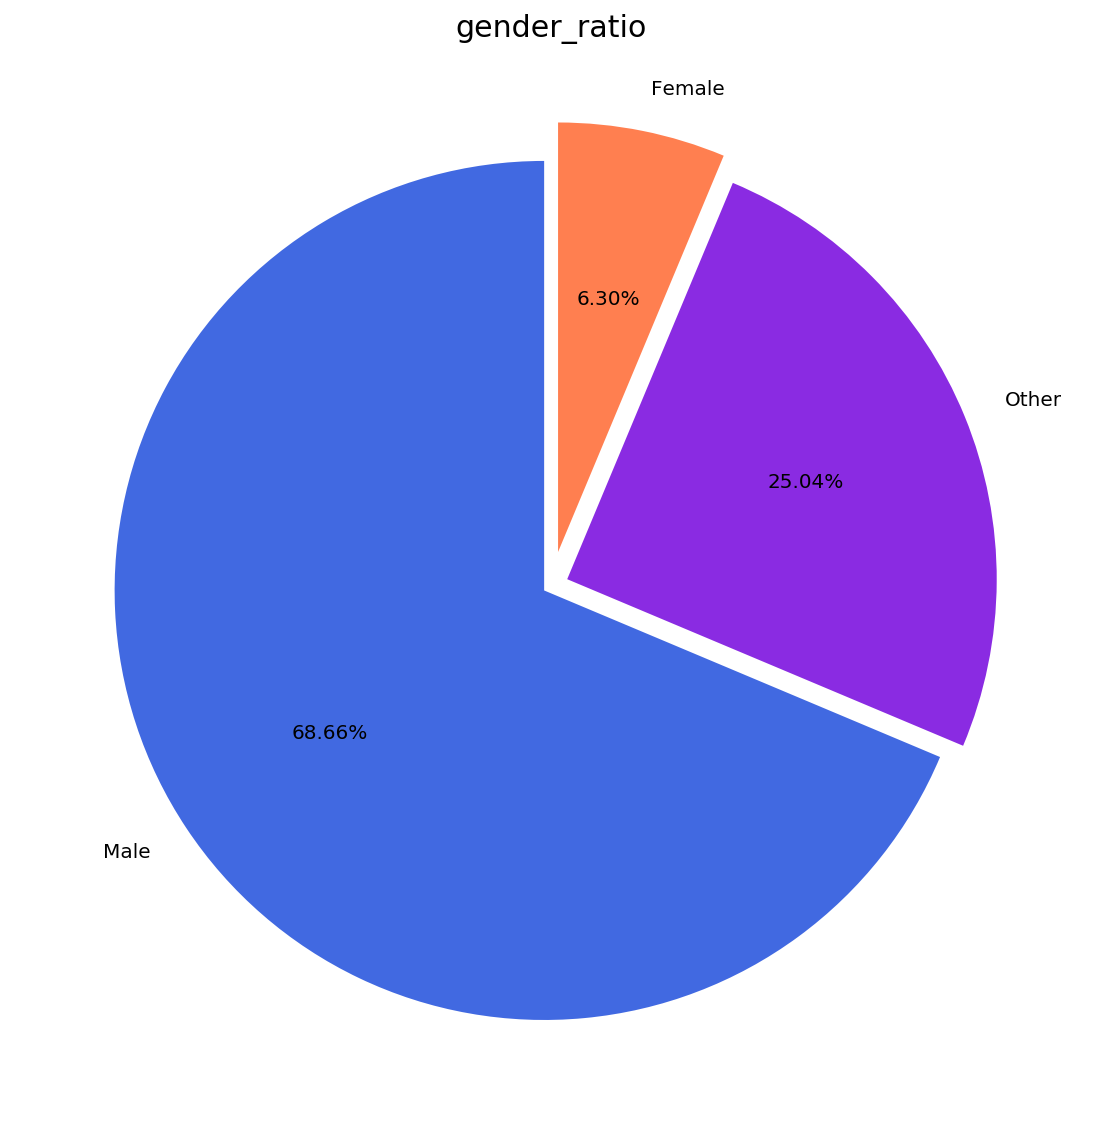

In [12]:
# 'gender' unique값들의 비율 시각화

gender_ratio = train['gender'].value_counts(normalize=True, dropna=False)
colormap1 = ['royalblue', 'blueviolet', 'coral']
plt.figure(figsize=(8, 8), facecolor='white', edgecolor='black', tight_layout=True)

plt.pie(
    gender_ratio,
    labels=gender_ratio.index,
    explode=[0.02, 0.04, 0.08],
    autopct="%.2f%%",
    startangle=90,
    colors=colormap1
)
plt.title("gender_ratio", size=15)
plt.show();

In [13]:
# 성별 별 이직의사 비율
print('Male\n', train.loc[train['gender'] == 'Male', 'target'].value_counts(normalize=True))
print('Other\n', train.loc[train['gender'] == 'Other', 'target'].value_counts(normalize=True))
print('Female\n', train.loc[train['gender'] == 'Female', 'target'].value_counts(normalize=True))

Male
 0.0    0.770839
1.0    0.229161
Name: target, dtype: float64
Other
 0.0    0.689129
1.0    0.310871
Name: target, dtype: float64
Female
 0.0    0.730769
1.0    0.269231
Name: target, dtype: float64


In [14]:
# 'relevent_experience' 이진 분류, int 변환 (No relevent experience = 0, Has relevent experience  = 1)

train['relevent_experience'] = train['relevent_experience'].str.replace('No relevent experience', '0')
train['relevent_experience'] = train['relevent_experience'].str.replace('0e', '0')
train['relevent_experience'] = train['relevent_experience'].str.replace('Has relevent experience', '1')
train['relevent_experience'] = train['relevent_experience'].astype(int)

In [15]:
train['relevent_experience'].value_counts(normalize=True)

1    0.718587
0    0.281413
Name: relevent_experience, dtype: float64

In [16]:
# 학력과 관련된 특성의 unique
# check
# 1. 최종학력이 대학 또는 대학원이라도 전공이 없는 후보자가 있음
# 2. 최종학력이 'Primary School', 'High School'라도 대학 또는 대학원 재학 중인 후보자가 있음

print(train['education_level'].unique())
print(train['enrolled_university'].unique())
print(train['major_discipline'].unique())

['Graduate' 'Masters' nan 'High School' 'Phd' 'Primary School']
['no_enrollment' 'Full time course' nan 'Part time course']
['STEM' 'No Major' nan 'Arts' 'Humanities' 'Business Degree' 'Other']


In [17]:
# 학력 정보 전체가 누락 된 경우는 학력이 없다고 가정 
# 'education_level'에 'uneducated' unique 추가

uneducated_candidate_index = train[train['education_level'].isnull() & train['enrolled_university'].isnull() & train['major_discipline'].isnull()].index

train.loc[uneducated_candidate_index, 'enrolled_university'] = 'no_enrollment'
train.loc[uneducated_candidate_index, 'education_level'] = 'uneducated'
train.loc[uneducated_candidate_index, 'major_discipline'] = 'No Major'

In [18]:
# 'enrolled_university'의 'Full time course' 'Part time course'는 의미가 불명확하다.
# 대학에 등록 되어 있는지 대학원에 등록 되어있는지 명확히 알 수 없고, 대학이나 대학원에 따라 기준이 나뉘기 때문이다.
# 따라서 대학이나 대학원에 등록된 즉 현재 재학 중인 후보자와 아닌 후보자로 구분 하겠다.
# 'no_enrollment' = 0, 'Full time course' & 'Part time course' = 1

train.loc[train['enrolled_university'] == 'no_enrollment', 'enrolled_university'] = 0
train.loc[train['enrolled_university'] == 'Full time course', 'enrolled_university'] = 1
train.loc[train['enrolled_university'] == 'Part time course', 'enrolled_university'] = 1

In [19]:
# 학력별 'major_discipline'의 unique값
# 'Primary School' 과 'High School'의 'major_discipline'값은 모두 nan 이라는 것을 확인 할 수 있음

print('Primary School :', train.loc[train['education_level'] == 'Primary School', 'major_discipline'].unique())
print('High School :', train.loc[train['education_level'] == 'High School', 'major_discipline'].unique())
print('Graduate :', train.loc[train['education_level'] == 'Graduate', 'major_discipline'].unique())
print('Phd :', train.loc[train['education_level'] == 'Phd', 'major_discipline'].unique())

Primary School : [nan]
High School : [nan]
Graduate : ['STEM' 'No Major' 'Arts' 'Humanities' 'Other' 'Business Degree' nan]
Phd : ['STEM' 'Humanities' 'Other' 'Arts' 'Business Degree']


In [20]:
# 표본 수가 부족하여 편향적인 값이 나왔다고 판단 하기에는 어려움

print('Primary School :', len(train.loc[train['education_level'] == 'Primary School', 'major_discipline']))
print(train.loc[train['education_level'] == 'Primary School', 'major_discipline'].isnull().value_counts(), '\n')
print('High School :', len(train.loc[train['education_level'] == 'High School', 'major_discipline']))
print(train.loc[train['education_level'] == 'High School', 'major_discipline'].isnull().value_counts(), '\n')

Primary School : 191
True    191
Name: major_discipline, dtype: int64 

High School : 1130
True    1130
Name: major_discipline, dtype: int64 



In [21]:
# 'High School', 'Primary School' 학력의 후보자의 'major_discipline'값을 'No Major'로 보간

train.loc[(train['education_level'] == 'High School'), 'major_discipline'] = 'No Major'
train.loc[(train['education_level'] == 'Primary School'), 'major_discipline'] = 'No Major'

In [22]:
# 'education_level'가 'Graduate'아며, 'major_discipline'가 nan인 경우는 극히 일부이다.
# 따라서 전체 표본에 큰 영향을 끼치지 않는다.

print(train.loc[train['education_level'] == 'Graduate', 'major_discipline'].isnull().value_counts(normalize=True))

False    0.998771
True     0.001229
Name: major_discipline, dtype: float64


In [23]:
# 'education_level'가 'Graduate'인 후보자의 'major_discipline' nan값을 'Other Major'로 보간

train.loc[train['education_level'] == 'Graduate', 'major_discipline'] = 'Other Major'

In [24]:
# 남은 학력 데이터의 nan값 교차 확인
# 'education_level'값이 nan일 때 'enrolled_university'는 모두 nan인 것을 확인 할 수 있음
# 반면 'enrolled_university'값이 nan일 때 'education_level'는 nan값이 없음

print('university & education \n', train.loc[train['enrolled_university'].isnull(), 'education_level'].isnull().value_counts(), '\n')
print('university & major \n', train.loc[train['enrolled_university'].isnull(), 'major_discipline'].isnull().value_counts(), '\n')
print('education & university \n', train.loc[train['education_level'].isnull(), 'enrolled_university'].isnull().value_counts(), '\n')
print('education & major \n', train.loc[train['education_level'].isnull(), 'major_discipline'].isnull().value_counts(), '\n')
print('major & university \n', train.loc[train['major_discipline'].isnull(), 'enrolled_university'].isnull().value_counts(), '\n')
print('major & education \n', train.loc[train['major_discipline'].isnull(), 'education_level'].isnull().value_counts(), '\n')

university & education 
 False    170
Name: education_level, dtype: int64 

university & major 
 False    170
Name: major_discipline, dtype: int64 

education & university 
 False    203
Name: enrolled_university, dtype: int64 

education & major 
 True    203
Name: major_discipline, dtype: int64 

major & university 
 False    206
Name: enrolled_university, dtype: int64 

major & education 
 True     203
False      3
Name: education_level, dtype: int64 



In [25]:
# 'education_level'가 nan 일 때 'relevent_experience'가 0이라면 'uneducated'라고 가정
# 'education_level'가 nan 일 때 'relevent_experience'가 1이라면 'education_level'을 'Graduate', 'major_discipline'을 'Other Major'로 가정
# 'Graduate'로 가정하는 이유는 'relevent_experience'가 1인 'education_level' 중 최빈값이 'Graduate'이기 때문

print(train.loc[train['enrolled_university'] == 1, 'education_level'].value_counts(normalize=True))

train.loc[train[train['education_level'].isnull()][train.loc[train[train['education_level'].isnull()].index, 'relevent_experience'] == 0].index, 'major_discipline'] = 'No Major'
train.loc[train[train['education_level'].isnull()][train.loc[train[train['education_level'].isnull()].index, 'relevent_experience'] == 1].index, 'major_discipline'] = 'Other Major'

train.loc[train[train['education_level'].isnull()][train.loc[train[train['education_level'].isnull()].index, 'relevent_experience'] == 0].index, 'education_level'] = 'uneducated'
train.loc[train[train['education_level'].isnull()][train.loc[train[train['education_level'].isnull()].index, 'relevent_experience'] == 1].index, 'education_level'] = 'Graduate'



Graduate          0.616569
High School       0.215909
Masters           0.149560
Primary School    0.010264
Phd               0.007698
Name: education_level, dtype: float64


In [26]:
# 나머지 'major_discipline'의 nan값 'Other Major'로 보간

train.loc[train['major_discipline'].isnull(), 'major_discipline'] = 'Other Major'

In [27]:
# 기존 'major_discipline'의 'Other'를 'Other Major'로 변경

train.loc[train['major_discipline'] == 'Other', 'major_discipline'] = 'Other Major'

0    0.736408
1    0.263592
Name: enrolled_university, dtype: float64


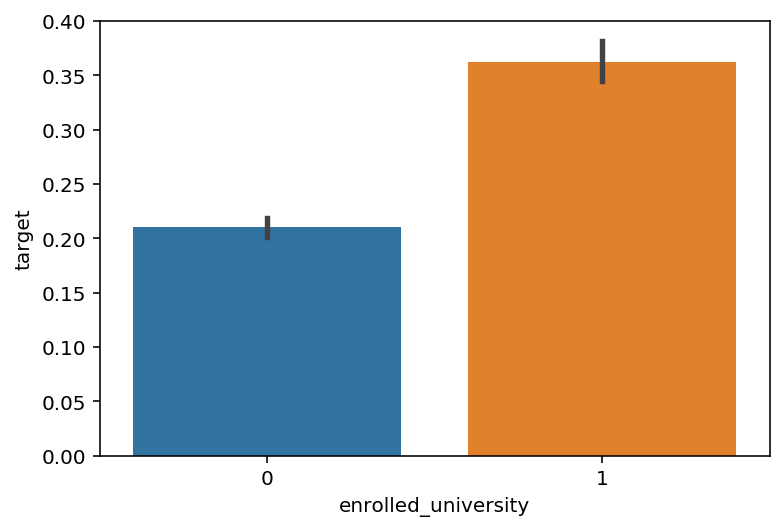

In [28]:
# 재학 중이지 않은 후보자 보다, 재학 중인 후보자가 이직 의사가 있을 확률이 더 높음
# 'enrolled_university'의 최빈값은 0
# 목적은 이직의사가 있는 후보자를 분류하기 위함이기 때문에, 이직의사가 있을 확률이 상대적으로 낮은 0에 노이즈가 생기는 것이 낫다고 판단.

print(train['enrolled_university'].value_counts(normalize=True))
sns.barplot(x='enrolled_university', y='target', data=train);

In [29]:
# 'enrolled_university'의 nan값을 0으로 보간

train[train['enrolled_university'].isnull()] = 0

In [30]:
# 'enrolled_university' dtype int로 변경

train['enrolled_university'] = train['enrolled_university'].astype(int)

In [31]:
train['education_level'].unique()

array(['Graduate', 'Masters', 'uneducated', 0, 'High School', 'Phd',
       'Primary School'], dtype=object)

In [32]:
# 학력을 순서형 데이터로 변경
# 'uneducated' = 0, 'Primary School' = 1, 'High School' = 2, 'Graduate' =3, 'Masters'=4, 'Phd'=5

train.loc[train['education_level'] == 'uneducated', 'education_level'] = 0
train.loc[train['education_level'] == 'Primary School', 'education_level'] = 1
train.loc[train['education_level'] == 'High School', 'education_level'] = 2
train.loc[train['education_level'] == 'Graduate', 'education_level'] = 3
train.loc[train['education_level'] == 'Masters', 'education_level'] = 4
train.loc[train['education_level'] == 'Phd', 'education_level'] = 5

train['education_level'] = train['education_level'].astype(int)

In [33]:
# 경력과 관련된 특성의 unique
# check
# 1. 관련 경험이 있다고 해서 경력이 인정 되는 것은 아니다
# 2. 'last_new_job'의 'never'은 중의적으로 해석 된다. 취업경험이 없는 무경력자인 경우 & 직업을 바꾼적이 없는 경우
# 3. 'experience'는 관련 경력만을 뜻 하는 것이 아니다.

print(train['relevent_experience'].unique())
print(train['experience'].unique())
print(train['company_size'].unique())
print(train['company_type'].unique())
print(train['last_new_job'].unique())

[1 0]
['11' '13' nan '17' '2' '4' '>20' '14' '9' '12' '10' 0 '5' '15' '<1' '7'
 '6' '8' '1' '3' '20' '19' '16' '18']
[nan '10000+' '100-500' '50-99' '500-999' '10/49' '<10' 0 '1000-4999'
 '5000-9999']
[nan 'Pvt Ltd' 'Funded Startup' 'NGO' 0 'Public Sector'
 'Early Stage Startup' 'Other']
['1' '2' 'never' '3' '>4' 0 '4' nan]


In [34]:
# 비정상적인 row 제거

print(train[train['company_type'] == 0].head())

train.drop(index=train[train['company_type'] == 0].index, inplace=True)

     city_development_index gender  relevent_experience  enrolled_university  \
14                      0.0      0                    0                    0   
42                      0.0      0                    0                    0   
70                      0.0      0                    0                    0   
92                      0.0      0                    0                    0   
114                     0.0      0                    0                    0   

     education_level major_discipline experience company_size company_type  \
14                 0                0          0            0            0   
42                 0                0          0            0            0   
70                 0                0          0            0            0   
92                 0                0          0            0            0   
114                0                0          0            0            0   

    last_new_job  training_hours  target  
14     

In [35]:
# 경력 데이터가 전부가 누락된 후보자는 취업경험이 없는 무경력자로 가정

inexperienced_candidate_index = train[train['experience'].isnull() & train['company_size'].isnull() & train['company_type'].isnull() & train['last_new_job'].isnull()].index

train.loc[inexperienced_candidate_index, 'experience'] = 'No Experience'
train.loc[inexperienced_candidate_index, 'company_size'] = 'Never Employed'
train.loc[inexperienced_candidate_index, 'company_type'] = 'Never Employed'
train.loc[inexperienced_candidate_index, 'last_new_job'] = 'Never Employed'

In [36]:
# 'last_new_job'가 'never'이면서, 'experience'가 nan인 후보자는 취업경험이 없는 무경력자로 가정
# + 'company_size'와 'company_type' 데이터가 nan인 후보자

inexperienced_candidate_index = train.loc[train['last_new_job'] == 'never', 'experience'][train.loc[train['last_new_job'] == 'never', 'experience'].isnull()].index
inexperienced_candidate_index = train.loc[inexperienced_candidate_index, 'company_size'][train.loc[inexperienced_candidate_index, 'company_size'].isnull()].index

train.loc[inexperienced_candidate_index, 'experience'] = 'No Experience'
train.loc[inexperienced_candidate_index, 'company_size'] = 'Never Employed'
train.loc[inexperienced_candidate_index, 'company_type'] = 'Never Employed'
train.loc[inexperienced_candidate_index, 'last_new_job'] = 'Never Employed'

In [37]:
# 경력이 있으나 직업을 바꾼적이 없는 경우의 'training_hours'의 'never'를 0으로 변경

train.loc[train['last_new_job'] == 'never', 'last_new_job'] = 0

In [38]:
# 나머지 경우의 nan은 추측 할 방법이 없기 때문에 'Unknow'으로 보간

train.loc[train['experience'].isnull(), 'experience'] = 'Unknow'
train.loc[train['company_size'].isnull(), 'company_size'] = 'Unknow'
train.loc[train['company_type'].isnull(), 'company_type'] = 'Unknow'
train.loc[train['last_new_job'].isnull(), 'last_new_job'] = 'Unknow'

In [39]:
# 경력과 관련된 특성의 특수문자, 구간처리를 위한 countplot

# fig, axes = plt.subplots(2,2, figsize = (30, 20))
plt.figure(figsize=(20, 10), facecolor='white', edgecolor='black', tight_layout=True)


features_2 = ['experience', 'company_size', 'company_type', 'last_new_job']

k=1
for i in range(len(features_2)):
  if k <= 4:
    plt.subplot(2,2,k)
    sns.countplot(train[features_2[i]])
    i += 1
    k += 1
    plt.grid(alpha = 0.5, linestyle = '--')
plt.show();

In [40]:
# 'experience'의 '>20'의 count가 불균형 하게 높은 것을 확인 할 수있음
# 다른 'experience'값이 섞여 있어 높은 count를 보인다고 가정. 5년 단위로 분류해 편향을 완화한다.

# 특수문자 제거
train['experience'] = train['experience'].str.replace('>', '')
train['experience'] = train['experience'].str.replace('<', '')

In [41]:
# 'experience'의 index를 5년 단위로 분류

No_Experience_index = train[train['experience'] == 'No Experience'].index
Unknow_index = train[train['experience'] == 'Unknow'].index

experience_Classification = train.drop(index=No_Experience_index)
experience_Classification = experience_Classification.drop(index=Unknow_index)

experience_Classification['experience'] = experience_Classification['experience'].astype(int)

range_16_20 =experience_Classification[experience_Classification['experience'] >= 16].index
range_11_15 =experience_Classification[(experience_Classification['experience'] < 16)  & (experience_Classification['experience'] >= 11)].index
range_6_10 = experience_Classification[(experience_Classification['experience'] < 11)  & (experience_Classification['experience'] >= 6)].index
range_1_5 = experience_Classification[experience_Classification['experience'] < 6].index

In [42]:
# 5년 단위로 각각 ['Top_Experience', 'High_Experience', 'Middle_Experience', 'Low_Experience']
# > 4, 3, 2, 1, 0, -1 순서형 데이터로 변환

train.loc[range_16_20, 'experience'] = '4'
train.loc[range_11_15, 'experience'] = '3'
train.loc[range_6_10, 'experience'] = '2'
train.loc[range_1_5, 'experience'] = '1'

train.loc[train['experience'] == 'No Experience', 'experience'] = 0
train.loc[train['experience'] == 'Unknow', 'experience'] = -1

train['experience'] = train['experience'].astype(int)

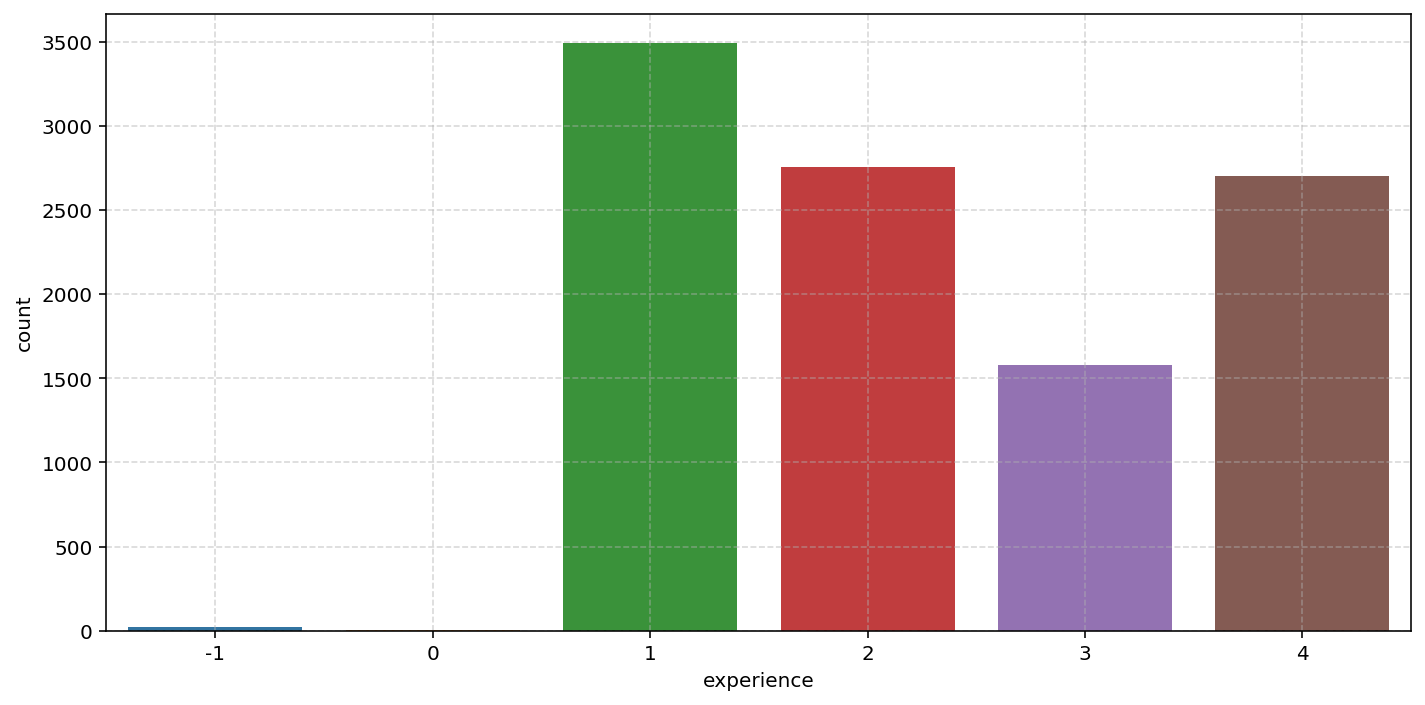

In [43]:
# 완화된 편향 확인

plt.figure(figsize=(10, 5), facecolor='white', edgecolor='black', tight_layout=True)
sns.countplot(train['experience'])
plt.grid(alpha = 0.5, linestyle = '--')
plt.show;

In [44]:
# 'company_size'의 '10/49'는 '1000~4999'의 표기 오류로 추정
# '10/49'를 '1000~4999'로 변경

train.loc[train['company_size'] == '10/49', 'company_size'] = '1000-4999'

In [45]:
# 'company_size' 각 범위의 중간값을 기준으로 수치형 데이터로 변경

train.loc[train['company_size'] == '10000+', 'company_size'] = 10000
train.loc[train['company_size'] == '5000-9999', 'company_size'] = 7500
train.loc[train['company_size'] == '1000-4999', 'company_size'] = 3000
train.loc[train['company_size'] == '500-999', 'company_size'] = 750
train.loc[train['company_size'] == '100-500', 'company_size'] = 300
train.loc[train['company_size'] == '50-99', 'company_size'] = 75
train.loc[train['company_size'] == '<10', 'company_size'] = 5
train.loc[train['company_size'] == 'Never Employed', 'company_size'] = 0
train.loc[train['company_size'] == 'Unknow', 'company_size'] = -1

train['company_size'] = train['company_size'].astype('float64')

In [46]:
# 'last_new_job'을 순서형 데이터로 변환
#  '>4'는 5로 변환

train.loc[train['last_new_job'] == '>4', 'last_new_job'] = 5
train.loc[train['last_new_job'] == '4', 'last_new_job'] = 4
train.loc[train['last_new_job'] == '3', 'last_new_job'] = 3
train.loc[train['last_new_job'] == '2', 'last_new_job'] = 2
train.loc[train['last_new_job'] == '1', 'last_new_job'] = 1
train.loc[train['last_new_job'] == 'Never Employed', 'last_new_job'] = 0
train.loc[train['last_new_job'] == 'Unknow', 'last_new_job'] = -1

train['last_new_job'] = train['last_new_job'].astype(int)

In [47]:
# 'target' dtype을 int로 변환

train['target'] = train['target'].astype(int)

In [48]:
# check

train_results, train_duplicated_rows = analysis_on_features(train)
print(f"duplicated = {train_duplicated_rows}\n", train_results)

duplicated = 72
                         null_count  num_unique_values    dtype
city_development_index           0                 91  float64
gender                           0                  3   object
relevent_experience              0                  2    int64
enrolled_university              0                  2    int64
education_level                  0                  6    int64
major_discipline                 0                  6   object
experience                       0                  6    int64
company_size                     0                  9  float64
company_type                     0                  8   object
last_new_job                     0                  7    int64
training_hours                   0                241    int64
target                           0                  2    int64


In [49]:
# validation, test set에 적용 할 함수 제작

def preprocessing(data):
    # 불필요한 특성 제거
    data.drop(columns='enrollee_id', inplace=True)
    data.drop(columns='city', inplace=True)

    # 'gender' nan값 'Other'로 보간
    data['gender'].fillna('Other', inplace=True)
    
    # 'relevent_experience' 이진 분류, int 변환
    data['relevent_experience'] = data['relevent_experience'].str.replace('No relevent experience', '0')
    data['relevent_experience'] = data['relevent_experience'].str.replace('0e', '0')
    data['relevent_experience'] = data['relevent_experience'].str.replace('Has relevent experience', '1')
    data['relevent_experience'] = data['relevent_experience'].astype(int)
    
    # 학력 정보 전체가 누락 된 경우는 학력이 없다고 가정 
    # 'education_level'에 'uneducated' unique 추가
    uneducated_candidate_index = data[data['education_level'].isnull() & data['enrolled_university'].isnull() & data['major_discipline'].isnull()].index
    data.loc[uneducated_candidate_index, 'enrolled_university'] = 'no_enrollment'
    data.loc[uneducated_candidate_index, 'education_level'] = 'uneducated'
    data.loc[uneducated_candidate_index, 'major_discipline'] = 'No Major'
    
    # 'no_enrollment' = 0, 'Full time course' & 'Part time course' = 1
    data.loc[data['enrolled_university'] == 'no_enrollment', 'enrolled_university'] = 0
    data.loc[data['enrolled_university'] == 'Full time course', 'enrolled_university'] = 1
    data.loc[data['enrolled_university'] == 'Part time course', 'enrolled_university'] = 1
    
    # 'High School', 'Primary School' 학력의 후보자의 'major_discipline'값을 'No Major'로 보간
    data.loc[(data['education_level'] == 'High School'), 'major_discipline'] = 'No Major'
    data.loc[(data['education_level'] == 'Primary School'), 'major_discipline'] = 'No Major'
    
    # 'education_level'가 'Graduate'인 후보자의 'major_discipline' nan값을 'Other Major'로 보간
    data.loc[data['education_level'] == 'Graduate', 'major_discipline'] = 'Other Major'
    
    # 'education_level'가 nan 일 때 'relevent_experience'가 0이라면 'uneducated'라고 가정
    # 'education_level'가 nan 일 때 'relevent_experience'가 1이라면 'education_level'을 'Graduate', 'major_discipline'을 'Other Major'로 가정
    data.loc[data[data['education_level'].isnull()][data.loc[data[data['education_level'].isnull()].index, 'relevent_experience'] == 0].index, 'major_discipline'] = 'No Major'
    data.loc[data[data['education_level'].isnull()][data.loc[data[data['education_level'].isnull()].index, 'relevent_experience'] == 1].index, 'major_discipline'] = 'Other Major'
    data.loc[data[data['education_level'].isnull()][data.loc[data[data['education_level'].isnull()].index, 'relevent_experience'] == 0].index, 'education_level'] = 'uneducated'
    data.loc[data[data['education_level'].isnull()][data.loc[data[data['education_level'].isnull()].index, 'relevent_experience'] == 1].index, 'education_level'] = 'Graduate'

    # 나머지 'major_discipline'의 nan값 'Other Major'로 보간
    data.loc[data['major_discipline'].isnull(), 'major_discipline'] = 'Other Major'
    
    # 기존 'major_discipline'의 'Other'를 'Other Major'로 변경
    data.loc[data['major_discipline'] == 'Other', 'major_discipline'] = 'Other Major'
    
    # 'enrolled_university'의 nan값을 0으로 보간
    data[data['enrolled_university'].isnull()] = 0

    # 'enrolled_university' dtype int로 변경
    data['enrolled_university'] = data['enrolled_university'].astype(int)
    
    # 학력을 순서형 데이터로 변경
    data.loc[data['education_level'] == 'uneducated', 'education_level'] = 0
    data.loc[data['education_level'] == 'Primary School', 'education_level'] = 1
    data.loc[data['education_level'] == 'High School', 'education_level'] = 2
    data.loc[data['education_level'] == 'Graduate', 'education_level'] = 3
    data.loc[data['education_level'] == 'Masters', 'education_level'] = 4
    data.loc[data['education_level'] == 'Phd', 'education_level'] = 5
    data['education_level'] = data['education_level'].astype(int)
    
    # 비정상적인 row 제거
    data.drop(index=data[data['company_type'] == 0].index, inplace=True)
    
    
    # 경력 데이터가 전부가 누락된 후보자는 취업경험이 없는 무경력자로 가정
    inexperienced_candidate_index = data[data['experience'].isnull() & data['company_size'].isnull() & data['company_type'].isnull() & data['last_new_job'].isnull()].index
    data.loc[inexperienced_candidate_index, 'experience'] = 'No Experience'
    data.loc[inexperienced_candidate_index, 'company_size'] = 'Never Employed'
    data.loc[inexperienced_candidate_index, 'company_type'] = 'Never Employed'
    data.loc[inexperienced_candidate_index, 'last_new_job'] = 'Never Employed'
    
    # 'last_new_job'가 'never'이면서, 'experience'가 nan인 후보자는 취업경험이 없는 무경력자로 가정
    # + 'company_size'와 'company_type' 데이터가 nan인 후보자
    inexperienced_candidate_index = data.loc[data['last_new_job'] == 'never', 'experience'][data.loc[data['last_new_job'] == 'never', 'experience'].isnull()].index
    inexperienced_candidate_index = data.loc[inexperienced_candidate_index, 'company_size'][data.loc[inexperienced_candidate_index, 'company_size'].isnull()].index
    data.loc[inexperienced_candidate_index, 'experience'] = 'No Experience'
    data.loc[inexperienced_candidate_index, 'company_size'] = 'Never Employed'
    data.loc[inexperienced_candidate_index, 'company_type'] = 'Never Employed'
    data.loc[inexperienced_candidate_index, 'last_new_job'] = 'Never Employed'
    
    # 경력이 있으나 직업을 바꾼적이 없는 경우의 'training_hours'의 'never'를 0으로 변경
    data.loc[data['last_new_job'] == 'never', 'last_new_job'] = 0
    
    # 나머지 경우의 nan은 추측 할 방법이 없기 때문에 'Unknow'으로 보간
    data.loc[data['experience'].isnull(), 'experience'] = 'Unknow'
    data.loc[data['company_size'].isnull(), 'company_size'] = 'Unknow'
    data.loc[data['company_type'].isnull(), 'company_type'] = 'Unknow'
    data.loc[data['last_new_job'].isnull(), 'last_new_job'] = 'Unknow'
    
    # 'experience' 특수문자 제거
    data['experience'] = data['experience'].str.replace('>', '')
    data['experience'] = data['experience'].str.replace('<', '')
    
    # 'experience'의 index를 5년 단위로 분류
    No_Experience_index = data[data['experience'] == 'No Experience'].index
    Unknow_index = data[data['experience'] == 'Unknow'].index
    experience_Classification = data.drop(index=No_Experience_index)
    experience_Classification = experience_Classification.drop(index=Unknow_index)
    experience_Classification['experience'] = experience_Classification['experience'].astype(int)
    range_16_20 =experience_Classification[experience_Classification['experience'] >= 16].index
    range_11_15 =experience_Classification[(experience_Classification['experience'] < 16)  & (experience_Classification['experience'] >= 11)].index
    range_6_10 = experience_Classification[(experience_Classification['experience'] < 11)  & (experience_Classification['experience'] >= 6)].index
    range_1_5 = experience_Classification[experience_Classification['experience'] < 6].index
    
    # > 4, 3, 2, 1, 0, -1 순서형 데이터로 변환
    data.loc[range_16_20, 'experience'] = '4'
    data.loc[range_11_15, 'experience'] = '3'
    data.loc[range_6_10, 'experience'] = '2'
    data.loc[range_1_5, 'experience'] = '1'
    data.loc[data['experience'] == 'No Experience', 'experience'] = 0
    data.loc[data['experience'] == 'Unknow', 'experience'] = -1
    data['experience'] = data['experience'].astype(int)
    
    # '10/49'를 '1000~4999'로 변경
    data.loc[data['company_size'] == '10/49', 'company_size'] = '1000-4999'
    
    # 'company_size' 각 범위의 중간값을 기준으로 수치형 데이터로 변경
    data.loc[data['company_size'] == '10000+', 'company_size'] = 10000
    data.loc[data['company_size'] == '5000-9999', 'company_size'] = 7500
    data.loc[data['company_size'] == '1000-4999', 'company_size'] = 3000
    data.loc[data['company_size'] == '500-999', 'company_size'] = 750
    data.loc[data['company_size'] == '100-500', 'company_size'] = 300
    data.loc[data['company_size'] == '50-99', 'company_size'] = 75
    data.loc[data['company_size'] == '<10', 'company_size'] = 5
    data.loc[data['company_size'] == 'Never Employed', 'company_size'] = 0
    data.loc[data['company_size'] == 'Unknow', 'company_size'] = -1
    data['company_size'] = data['company_size'].astype('float64')
    
    # 'last_new_job'을 순서형 데이터로 변환
    #  '>4'는 5로 변환
    data.loc[data['last_new_job'] == '>4', 'last_new_job'] = 5
    data.loc[data['last_new_job'] == '4', 'last_new_job'] = 4
    data.loc[data['last_new_job'] == '3', 'last_new_job'] = 3
    data.loc[data['last_new_job'] == '2', 'last_new_job'] = 2
    data.loc[data['last_new_job'] == '1', 'last_new_job'] = 1
    data.loc[data['last_new_job'] == 'Never Employed', 'last_new_job'] = 0
    data.loc[data['last_new_job'] == 'Unknow', 'last_new_job'] = -1
    data['last_new_job'] = data['last_new_job'].astype(int)
    
    # 'target' dtype을 int로 변환
    data['target'] = data['target'].astype(int)

In [50]:
# validation, test set에 preprocessing 적용
preprocessing(val)
preprocessing(test)

In [51]:
train.columns

Index(['city_development_index', 'gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours', 'target'],
      dtype='object')

In [59]:
sns.lineplot(x='education_level', y='training_hours', data=train)

# 모델 학습 및 검증
* 실제 이직 의사가 없는데 이직의사가 있다고 예측한 경우 FP 'Type 1 error'
* 실제 이직 의사가 있는데 이직의사가 없다고 예측한 경우 FN 'Type 2 error'

해결 하고자 하는 문제는 이직의사가 여부를 예측하여, 회사에 고용 할 수 있는 가능성이 높은 후보자를 찾아내는 것

즉 교육 자원 비용을 줄이는 것이 목표이다.

때문에, 이직의사가 있는 후보자를 찾는 것과 이직의사가 없는 후보자를 최대한 많이 가려내는 것 모두 중요하다

평가지표 accuracy_score

In [51]:
# baseline은 target의 최빈값으로 한다.

target_mode = train['target'].mode()[0]
baseline = [target_mode] * len(train['target'])

In [52]:
# baseline의 검증 정확도

accuracy_score(baseline, train['target'])

0.7496684978215571

In [53]:
#  feature(X), label(y) 분할 함수

def divide_data(df):
    target = 'target'
    X = df.drop(columns=target)
    y = df[target]
    return X, y

In [54]:
# train, val, test feature, label 분할

X_train, y_train = divide_data(train)
X_val, y_val = divide_data(val)
X_test, y_test = divide_data(test)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(10558, 11) (10558,) (4539, 11) (4539,) (3775, 11) (3775,)


In [55]:
# RandomizedSearchCV를 이용한 모델 파라미터 최적화 함수

def fit(X_train, y_train):


    pipeline =  make_pipeline(
        BinaryEncoder()
        ,XGBClassifier(random_state=2)
    )

    params = {
        'xgbclassifier__learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
        'xgbclassifier__max_depth' : [4, 5, 6],
        'xgbclassifier__min_child_weight' : [ 1, 3, 5, 7 ],
        'xgbclassifier__gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
        'xgbclassifier__colsample_bytree' : [0.7],
        'xgbclassifier__scale_pos_weight' : [2, 2.5, 3, 3.5, 4, 4.5]
    }

    clf = RandomizedSearchCV(pipeline
                       ,param_distributions=params
                       ,n_iter=200
                       ,scoring='accuracy'
                       ,n_jobs=-1
                       ,cv=5
                       ,verbose=3
                       ,random_state=142
    )


    clf.fit(X_train, y_train)
    print("Optimal Hyperparameter:", clf.best_params_)
    print("AUC:", clf.best_score_)

    return clf

In [56]:
# 평가 지표 함수

def predict(X, y, best_estimator):
    pipe = best_estimator

    y_pred_proba = pipe.predict_proba(X)[:, 1]
    

    report = classification_report(y, y_pred_proba > 0.5)
    return y_pred_proba, report

In [57]:
clf = fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 4/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.2, xgbclassifier__learning_rate=0.2, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__scale_pos_weight=4;, score=0.779 total time=   0.5s
[CV 2/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.15, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=7, xgbclassifier__scale_pos_weight=4;, score=0.754 total time=   0.6s
[CV 1/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.4, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=3, xgbclassifier__scale_pos_weight=3;, score=0.788 total time=   0.8s
[CV 2/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.4, xgbclassifier__learning_rate=0.15, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__scale_pos_weight=3;, score

[CV 5/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.0, xgbclassifier__learning_rate=0.25, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=5, xgbclassifier__scale_pos_weight=2.5;, score=0.790 total time=   0.6s
[CV 4/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.2, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=5, xgbclassifier__scale_pos_weight=4.5;, score=0.766 total time=   0.7s
[CV 5/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.3, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=1, xgbclassifier__scale_pos_weight=4;, score=0.769 total time=   0.7s
[CV 5/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.15, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=7, xgbclassifier__scale_pos_weight=3.5;, score=0.783 total time=   0.8s
[CV 5/5] END xgbclassifier__cols

[CV 1/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.0, xgbclassifier__learning_rate=0.2, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=1, xgbclassifier__scale_pos_weight=2;, score=0.811 total time=   0.8s
[CV 1/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.25, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=3, xgbclassifier__scale_pos_weight=4.5;, score=0.775 total time=   0.8s
[CV 2/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.2, xgbclassifier__learning_rate=0.25, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=5, xgbclassifier__scale_pos_weight=3.5;, score=0.754 total time=   0.8s
[CV 2/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.0, xgbclassifier__learning_rate=0.2, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=7, xgbclassifier__scale_pos_weight=2.5;, score=0.777 total time=   0.5s
[CV 2/5] END xgbclassifier__cols

[CV 2/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.2, xgbclassifier__learning_rate=0.2, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__scale_pos_weight=4;, score=0.749 total time=   0.5s
[CV 5/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.15, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=7, xgbclassifier__scale_pos_weight=4;, score=0.764 total time=   0.6s
[CV 5/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.4, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=3, xgbclassifier__scale_pos_weight=3;, score=0.783 total time=   0.8s
[CV 5/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.4, xgbclassifier__learning_rate=0.15, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__scale_pos_weight=3;, score=0.787 total time=   0.6s
[CV 4/5] END xgbclassifier__colsample_

[CV 3/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.2, xgbclassifier__learning_rate=0.2, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__scale_pos_weight=4;, score=0.781 total time=   0.5s
[CV 3/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.15, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=7, xgbclassifier__scale_pos_weight=4;, score=0.782 total time=   0.6s
[CV 4/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.4, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=3, xgbclassifier__scale_pos_weight=3;, score=0.790 total time=   0.8s
[CV 4/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.4, xgbclassifier__learning_rate=0.15, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__scale_pos_weight=3;, score=0.798 total time=   0.7s
[CV 5/5] END xgbclassifier__colsample_

Optimal Hyperparameter: {'xgbclassifier__scale_pos_weight': 2, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__gamma': 0.3, 'xgbclassifier__colsample_bytree': 0.7}
AUC: 0.8046039504471526


In [58]:
def plot_roc(y, y_pred_proba):
    auc_score = roc_auc_score(y, y_pred_proba)
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    baseline_fpr, baseline_tpr, _ = roc_curve(y, [0] * len(y))

    plt.style.use("ggplot")
    plt.plot(fpr, tpr, label="Model")
    plt.plot(baseline_fpr, baseline_tpr, linestyle="--", label="Baseline")
    plt.xlabel("False Positive Rate", size=12)
    plt.ylabel("True Positive Rate", size=12)
    plt.title("Receiver Operating Characteristic")
    plt.legend(prop={"size": 12})
    plt.show()
    return auc_score

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      3437
           1       0.56      0.67      0.61      1102

    accuracy                           0.79      4539
   macro avg       0.73      0.75      0.74      4539
weighted avg       0.81      0.79      0.80      4539



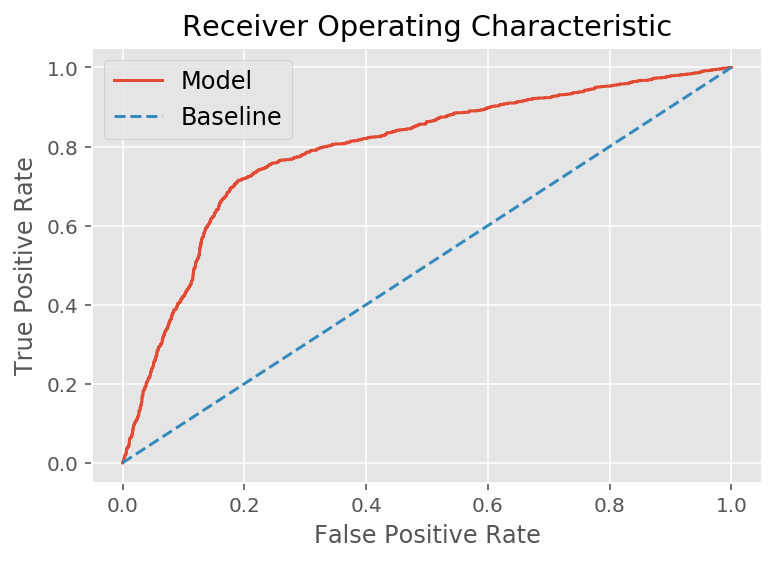

In [59]:
y_val_pred_proba, report = predict(X_val, y_val, clf.best_estimator_)
print(report)
auc_score = plot_roc(y_val, y_val_pred_proba)

In [60]:
# 최종 모델

pipe = Pipeline([
    ('preprocessing', make_pipeline(BinaryEncoder())),
    ('XGB', XGBClassifier(n_estimators=1000,
                   max_depth=5, 
                   learning_rate=0.05,
                   n_jobs=-1, 
                   random_state=2,
                   gamma=0.3,
                   min_child_weight=5,
                   scale_pos_weight=2,
                   colsample_bytree=0.7)) 
])

In [61]:
pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  0.7902621722846442


In [62]:
# permuter 정의

permuter = PermutationImportance(
    pipe.named_steps['XGB'],
    scoring='accuracy',
    n_iter=5, 
    random_state=2
)

X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)
X_train_transformed = pipe.named_steps['preprocessing'].transform(X_train)

permuter.fit(X_val_transformed, y_val);

In [63]:
# 순열 중요도

feature_names = X_val_transformed.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

city_development_index    0.118044
company_size              0.019255
education_level           0.014364
company_type_2            0.007138
last_new_job              0.002644
experience                0.002115
relevent_experience       0.001895
major_discipline_1        0.001278
gender_0                  0.000705
gender_1                  0.000485
company_type_0            0.000000
training_hours           -0.000044
company_type_1           -0.000264
enrolled_university      -0.000441
major_discipline_2       -0.000749
major_discipline_0       -0.000837
company_type_3           -0.001190
dtype: float64

In [64]:
# 순열 중요도가 낮은 특성 제거

minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_val_transformed.columns[mask]
X_train_selected = X_train_transformed[features]
X_val_selected = X_val_transformed[features]

In [65]:
# pipeline 초기화 재학습
pipe = Pipeline([
    ('preprocessing', make_pipeline(BinaryEncoder())),
    ('XGB', XGBClassifier(n_estimators=1000,
                   max_depth=5, 
                   learning_rate=0.05,
                   n_jobs=-1, 
                   random_state=2,
                   gamma=0.3,
                   min_child_weight=5,
                   scale_pos_weight=2,
                   colsample_bytree=0.7)) 
])

pipe.fit(X_train_selected, y_train);

In [66]:
print('검증 정확도: ', pipe.score(X_val_selected, y_val))

검증 정확도:  0.7889402952192113


In [67]:
# 결과의 큰 차이가 없기 때문에 해석의 용이함을 위해 특성 제거를 진행하지 않음
pipe = Pipeline([
    ('preprocessing', make_pipeline(BinaryEncoder())),
    ('XGB', XGBClassifier(n_estimators=1000,
                   max_depth=5, 
                   learning_rate=0.05,
                   n_jobs=-1, 
                   random_state=2,
                   gamma=0.3,
                   min_child_weight=5,
                   scale_pos_weight=2,
                   colsample_bytree=0.7)) 
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('binaryencoder', BinaryEncoder())])),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0.3, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.05, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=5, max_leaves=0, min_child_weight=5,
                               missing=nan, monotone_constraints='()',
                               n_estimators=1000, n_jobs=-1,
                               num_parallel_tree=1, predictor='auto',
                               random_state=2, reg_alpha=0, reg_lambda=1, ...))])

In [68]:
def predict(X, y, best_estimator):
    pipe = best_estimator

    y_pred_proba = pipe.predict_proba(X)[:, 1]
    

    report = classification_report(y, y_pred_proba > 0.6)
    return y_pred_proba, report

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2847
           1       0.59      0.61      0.60       928

    accuracy                           0.80      3775
   macro avg       0.73      0.73      0.73      3775
weighted avg       0.80      0.80      0.80      3775



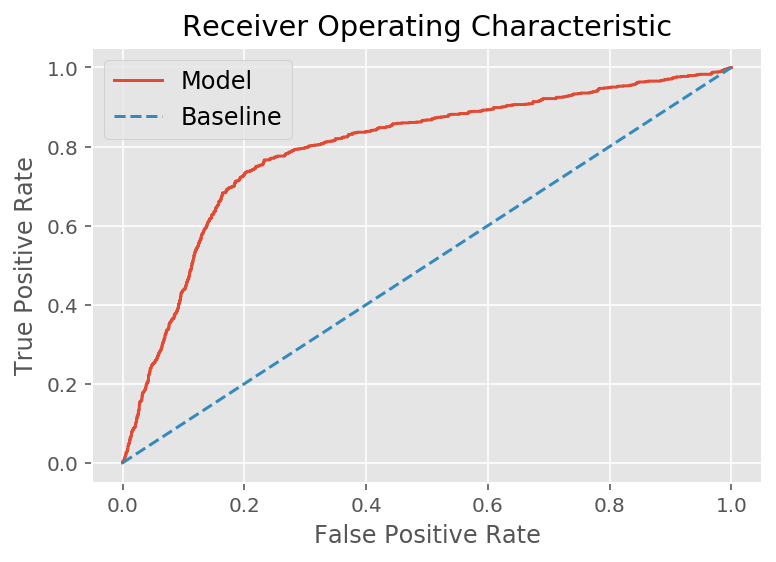

In [69]:
y_test_pred_proba, report = predict(X_test, y_test, pipe)
print(report)
auc_score = plot_roc(y_test, y_test_pred_proba)

# 모델 해석

* 모델 평가

    test score는 기준모델 대비 accuracy가 약 0.05 상승 한 0.80이다.
    
    검증 데이터 셋의 accuracy가 0.79에 비해 test score가 상승 한 것으로 보았을 때 일반화 성능이 좋은 모델로 확인 할 수 있음

In [70]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact_plot, pdp_interact


In [71]:
encoder = BinaryEncoder()

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

boosting = XGBClassifier(n_estimators=1000,
                   max_depth=5, 
                   learning_rate=0.05,
                   n_jobs=-1, 
                   random_state=2,
                   gamma=0.3,
                   min_child_weight=5,
                   scale_pos_weight=2,
                   colsample_bytree=0.7,
)


eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

boosting.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=100
         )

[0]	validation_0-logloss:0.67604	validation_1-logloss:0.67653
[1]	validation_0-logloss:0.66541	validation_1-logloss:0.66601
[2]	validation_0-logloss:0.64961	validation_1-logloss:0.65071
[3]	validation_0-logloss:0.63555	validation_1-logloss:0.63711
[4]	validation_0-logloss:0.62362	validation_1-logloss:0.62568
[5]	validation_0-logloss:0.61158	validation_1-logloss:0.61430
[6]	validation_0-logloss:0.60512	validation_1-logloss:0.60799
[7]	validation_0-logloss:0.59436	validation_1-logloss:0.59780
[8]	validation_0-logloss:0.58510	validation_1-logloss:0.58900
[9]	validation_0-logloss:0.57652	validation_1-logloss:0.58094
[10]	validation_0-logloss:0.57107	validation_1-logloss:0.57576
[11]	validation_0-logloss:0.56357	validation_1-logloss:0.56865
[12]	validation_0-logloss:0.55661	validation_1-logloss:0.56223
[13]	validation_0-logloss:0.55031	validation_1-logloss:0.55653
[14]	validation_0-logloss:0.54348	validation_1-logloss:0.55021
[15]	validation_0-logloss:0.53748	validation_1-logloss:0.54474
[1

[130]	validation_0-logloss:0.42982	validation_1-logloss:0.47150
[131]	validation_0-logloss:0.42970	validation_1-logloss:0.47155
[132]	validation_0-logloss:0.42950	validation_1-logloss:0.47151
[133]	validation_0-logloss:0.42940	validation_1-logloss:0.47156
[134]	validation_0-logloss:0.42913	validation_1-logloss:0.47155
[135]	validation_0-logloss:0.42895	validation_1-logloss:0.47151
[136]	validation_0-logloss:0.42868	validation_1-logloss:0.47149
[137]	validation_0-logloss:0.42858	validation_1-logloss:0.47149
[138]	validation_0-logloss:0.42843	validation_1-logloss:0.47150
[139]	validation_0-logloss:0.42821	validation_1-logloss:0.47148
[140]	validation_0-logloss:0.42807	validation_1-logloss:0.47146
[141]	validation_0-logloss:0.42794	validation_1-logloss:0.47151
[142]	validation_0-logloss:0.42776	validation_1-logloss:0.47147
[143]	validation_0-logloss:0.42760	validation_1-logloss:0.47149
[144]	validation_0-logloss:0.42746	validation_1-logloss:0.47151
[145]	validation_0-logloss:0.42725	valid

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=2,
              reg_alpha=0, reg_lambda=1, ...)

In [72]:
feature = ['gender_0', 'gender_1']

isolated = pdp_isolate(
    model=boosting, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

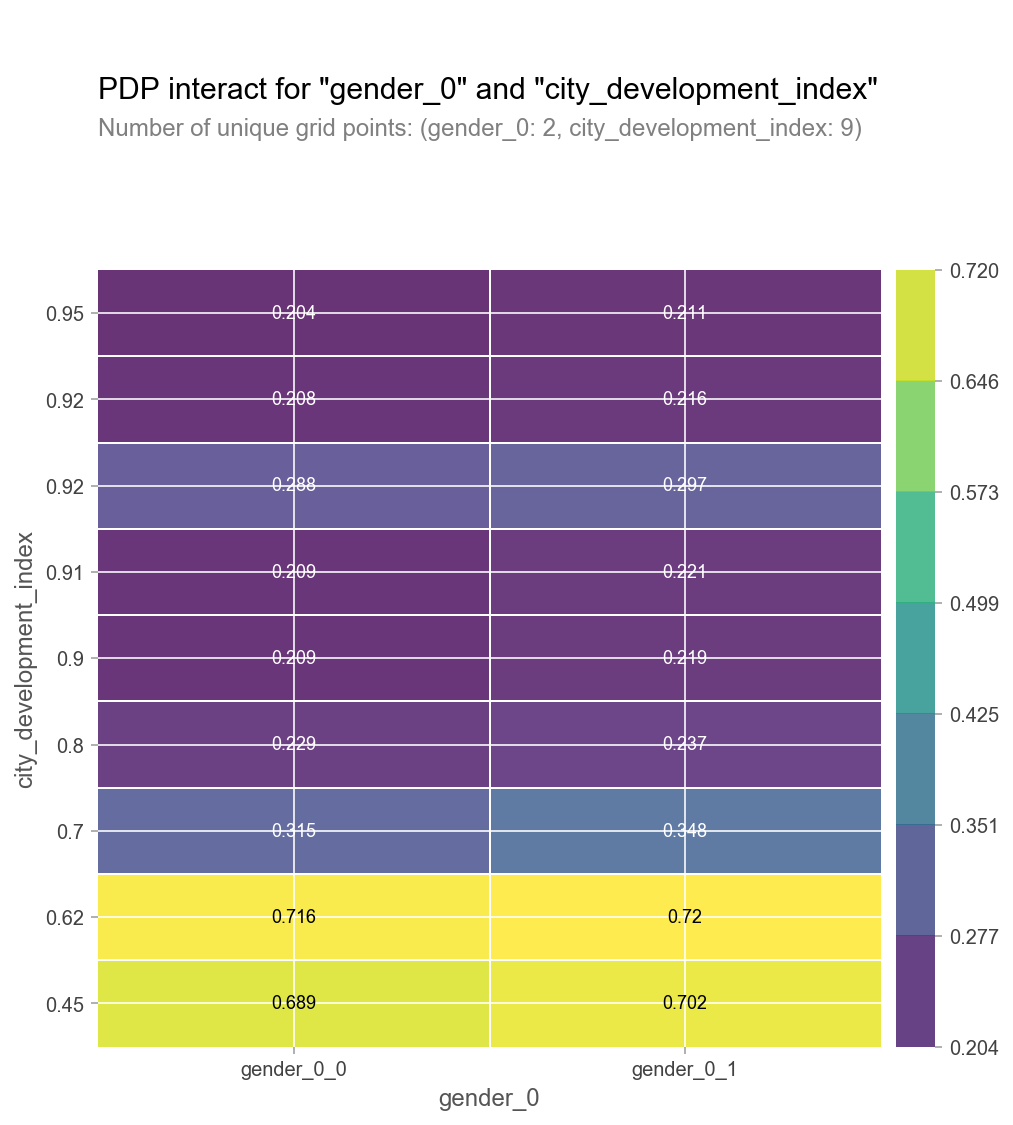

In [73]:
# 2D PDP
features = ['gender_0', 'city_development_index']

interaction = pdp_interact(
    model=boosting, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [74]:
features = ['gender_1', 'city_development_index']

interaction = pdp_interact(
    model=boosting, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

BinaryEncoder를 사용 하였기 때문에 pdpplot으로는 해석이 어려움

In [90]:
row = X_test.iloc[:1000]
row

city_development_index  gender  relevent_experience  \
0                      0.910   Other                    1   
1                      0.920  Female                    1   
2                      0.924   Other                    1   
3                      0.624    Male                    1   
4                      0.698    Male                    0   
...                      ...     ...                  ...   
1011                   0.624    Male                    1   
1012                   0.920    Male                    1   
1013                   0.624   Other                    0   
1014                   0.920    Male                    1   
1015                   0.920  Female                    0   

      enrolled_university  education_level major_discipline  experience  \
0                       0                3      Other Major           2   
1                       0                4       Humanities           4   
2                       0                3      Other Major           2   
3                       0                4             STEM           3   
4                       0                4             STEM           3   
...                   ...              ...              ...         ...   
1011                    0                3      Other Major           1   
1012                    0                4             STEM           4   
1013                    1                2         No Major           2   
1014                    0                4             STEM          -1   
1015                    1                3      Other Major           1   

      company_size    company_type  last_new_job  training_hours  
0            750.0         Pvt Ltd             1              21  
1            300.0  Funded Startup             2              74  
2           3000.0         Pvt Ltd             1              94  
3          10000.0         Pvt Ltd             1              75  
4            750.0             NGO             1             157  
...            ...             ...           ...             ...  
1011        3000.0         Pvt Ltd             1              58  
1012          -1.0          Unknow             5              52  
1013          -1.0          Unknow             1              16  
1014       10000.0         Pvt Ltd             1             136  
1015       10000.0   Public Sector             1              69  

[1000 rows x 11 columns]

In [91]:
import shap

processor = BinaryEncoder()

explainer = shap.TreeExplainer(boosting)
row_processed = encoder.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row_processed, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

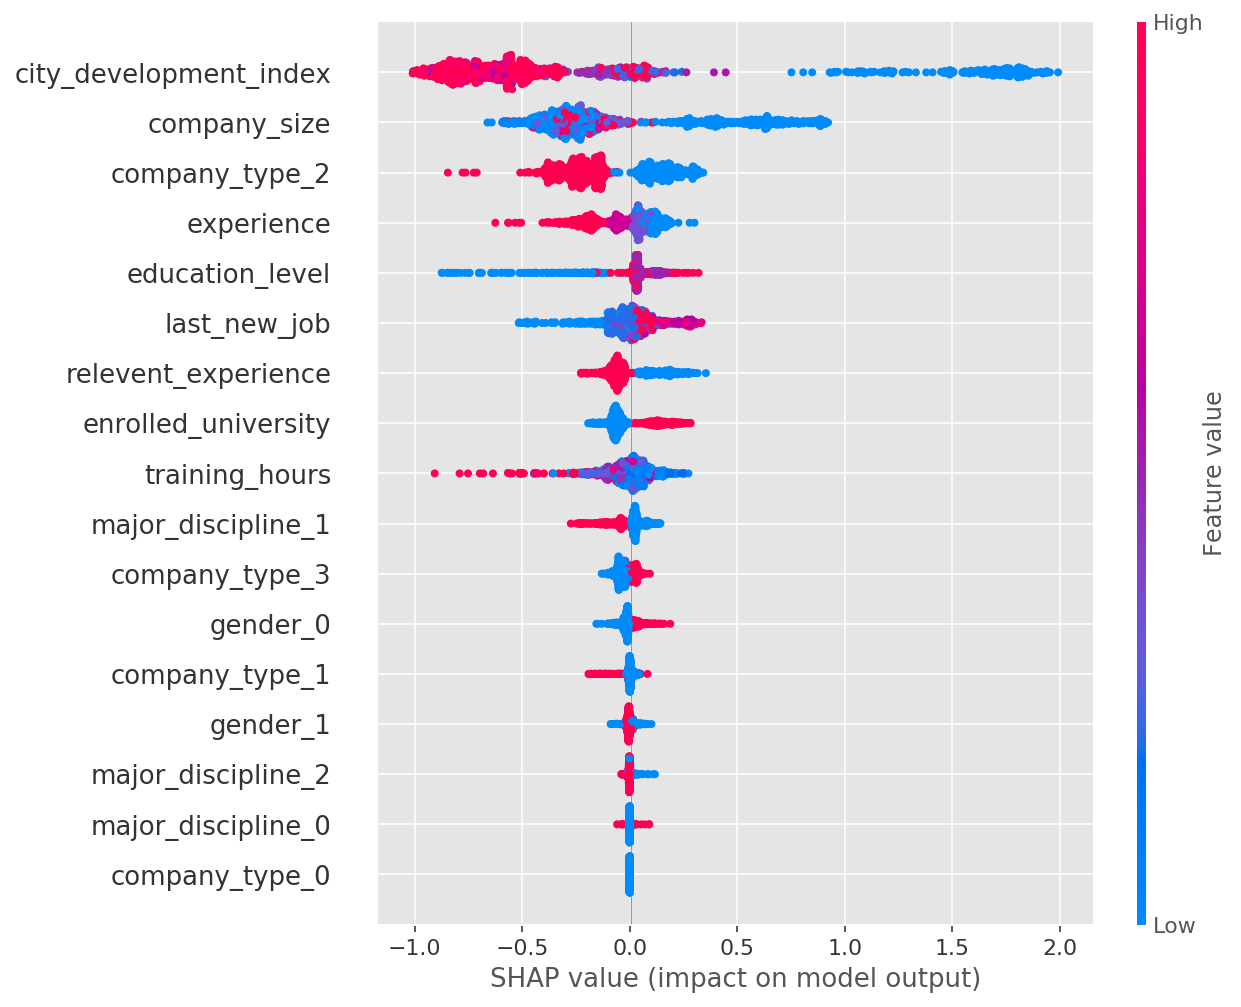

In [93]:
shap_values = explainer.shap_values(row_processed.iloc[:1000])
shap.summary_plot(shap_values, row_processed.iloc[:1000])

In [94]:
shap.summary_plot(shap_values, row_processed.iloc[:1000], plot_type="bar")


[CV 1/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.0, xgbclassifier__learning_rate=0.15, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=5, xgbclassifier__scale_pos_weight=3.5;, score=0.787 total time=   0.6s
[CV 1/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.3, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=7, xgbclassifier__scale_pos_weight=2.5;, score=0.810 total time=   0.6s
[CV 1/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.3, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__scale_pos_weight=4;, score=0.776 total time=   0.5s
[CV 1/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.2, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__scale_pos_weight=2;, score=0.814 total time=   0.5s
[CV 1/5] END xgbclassifier__colsam

[CV 1/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.2, xgbclassifier__learning_rate=0.2, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__scale_pos_weight=4;, score=0.779 total time=   0.5s
[CV 1/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.15, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=7, xgbclassifier__scale_pos_weight=4;, score=0.776 total time=   0.7s
[CV 2/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.4, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=3, xgbclassifier__scale_pos_weight=3;, score=0.754 total time=   0.8s
[CV 1/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.4, xgbclassifier__learning_rate=0.15, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__scale_pos_weight=3;, score=0.804 total time=   0.6s
[CV 1/5] END xgbclassifier__colsample_

[CV 2/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=1, xgbclassifier__scale_pos_weight=3;, score=0.770 total time=   0.7s
[CV 2/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.3, xgbclassifier__learning_rate=0.2, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=3, xgbclassifier__scale_pos_weight=2;, score=0.776 total time=   0.8s
[CV 2/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.0, xgbclassifier__learning_rate=0.25, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__scale_pos_weight=4;, score=0.750 total time=   0.5s
[CV 4/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.4, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__scale_pos_weight=4.5;, score=0.766 total time=   0.5s
[CV 4/5] END xgbclassifier__colsample

[CV 2/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.0, xgbclassifier__learning_rate=0.15, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=5, xgbclassifier__scale_pos_weight=3.5;, score=0.758 total time=   0.7s
[CV 2/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.3, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=7, xgbclassifier__scale_pos_weight=2.5;, score=0.779 total time=   0.7s
[CV 2/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.3, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__scale_pos_weight=4;, score=0.748 total time=   0.7s
[CV 5/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.2, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__scale_pos_weight=2;, score=0.798 total time=   0.5s
[CV 5/5] END xgbclassifier__colsam

In [ ]:
sns.lineplot(x=)